# Top 10000 topics on reddit

In [108]:
import pandas as pd
import numpy as np
import praw
from matplotlib import pyplot as plt
import seaborn as sns

# PSAW Approach

Tried using PSAW module to pull 10,000 threads, because that's not supported in PRAW. Instead only got author IDs.
Have to look for a new approach

Drawbacks of PSAW:
1. Returns only reddit IDs
2. Have to mention a subreddit, can't use 'all'

In [140]:
from psaw import PushshiftAPI
r = praw.Reddit(client_id='Sqc3X3Z6cfeHDbybfiiW9Q', 
                     client_secret='c83zLdpcAHiXCDg5V5unVL5BpyLBkQ', 
                     user_agent='scraper_101', 
                     username='lotta_true_crime ', 
                     password='renuka21')
api = PushshiftAPI(r)
gen = api.search_submissions(limit=10000,filter=['url','author', 'title', 'subreddit','upvote_ratio','selftext'],subreddit='funny')
results = list(gen)

In [146]:
df_no= pd.DataFrame(results)
print('shape:',df_no.shape)
df_no.head(5)

shape: (9998, 1)


,0
0,vdnsoq
1,vdns4b
2,vdnmky
3,vdnmkj
4,vdnm75


### PRAW Approach

In [155]:
reddit = praw.Reddit(client_id='Sqc3X3Z6cfeHDbybfiiW9Q', 
                     client_secret='c83zLdpcAHiXCDg5V5unVL5BpyLBkQ', 
                     user_agent='scraper_101', 
                     username='lotta_true_crime ', 
                     password='renuka21')

In [160]:
start_year = 2022  # '2021-01-01 00:00:00' in Unix time
end_year = 2022  # '2021-02-28 23:59:59' in Unix time
no_subreddit = reddit.subreddit('all')
new = no_subreddit.top(limit=10000,time_filter='all')
# can get comments as well, has to initiate commenttree to access

In [161]:
dict =        { "title":[],
                "subreddit":[],
                "Upvotes":[],
                "Upvote_ratio":[],
                "id":[], 
                "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[],
                "NSFW(Not safe for work)":[] }
for submission in new:
    dict["title"].append(submission.title)
    dict['subreddit'].append(submission.subreddit)
    dict["Upvotes"].append(submission.score)
    dict["id"].append(submission.id)
    dict["url"].append(submission.url)
    dict['Upvote_ratio'].append(submission.upvote_ratio)
    dict["comms_num"].append(submission.num_comments)
    dict["created"].append(submission.created)
    dict["body"].append(submission.selftext)
    dict["NSFW(Not safe for work)"].append(submission.over_18)

In [178]:
df = pd.DataFrame(dict)
df.drop_duplicates(subset=['id'], inplace=True)
import datetime as dt
def get_date(created):
    return dt.datetime.fromtimestamp(created)
x=[]
for i in df['created']:
    x.append(get_date(i))
df['DateTime']=x
df.drop(['created'],axis=1,inplace=True)
df.shape
# able to get only 2413, no matter how high I specify the limit. have to look for other alternatives.

(2413, 10)

In [179]:
# Not safe for work
df['NSFW(Not safe for work)'].value_counts()

False    2407
True        6
Name: NSFW(Not safe for work), dtype: int64

In [181]:
# Saving
df.to_csv('16_jun_top.csv')

In [182]:
text= df['title'].sum()

In [183]:
text=text.replace('.','')
text=text.replace(',','')
text=text.replace('!','')
text=text.replace('(','')
text=text.replace(')','')
text=text.replace('=','')
text=text.replace(']','')
text=text.replace('[','')
text= text.lower()

### WordCloud of the titles

In [184]:
df_st= pd.read_excel(r'C:\Users\lenovo\Desktop\data\stop.xlsx')
s=set(df_st['stopwords'])

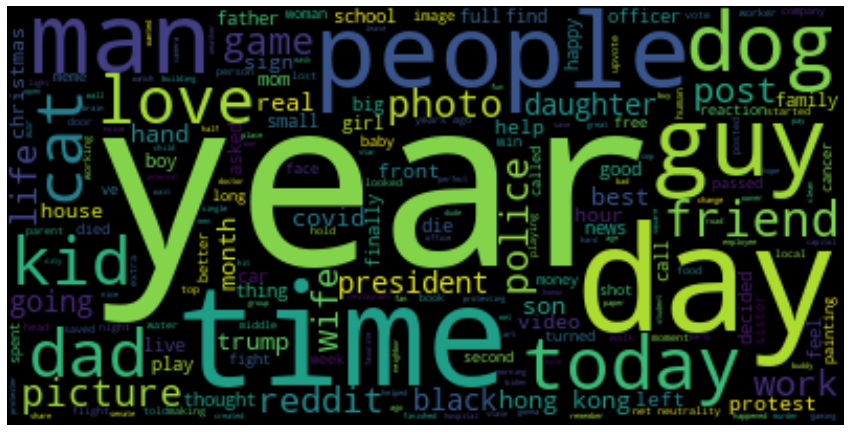

In [185]:
from wordcloud import WordCloud, STOPWORDS
s.update(STOPWORDS)
cloud= WordCloud(stopwords=s).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud of the body

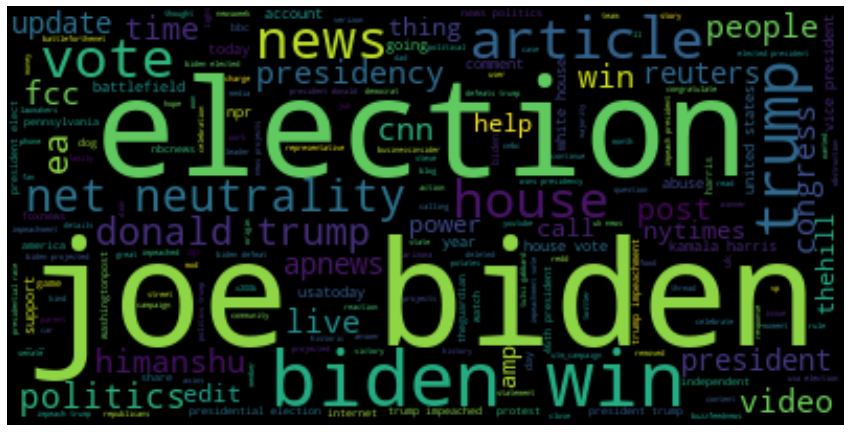

In [186]:
text_1= df['body'].sum()
text_1= text_1.lower()
s.update(['u','https','reddit','will','c','see','will','html','org','v','10','1','2','3','4','5'])
cloud_1= WordCloud(stopwords=s).generate(text_1)
plt.figure(figsize=(15,15))
plt.imshow(cloud_1,interpolation='bilinear')
plt.axis('off')
plt.show()

In [187]:
from nltk.tokenize import RegexpTokenizer
tok= RegexpTokenizer('\w+')
tokss= tok.tokenize(text_1)
tok=[]
for k in tokss:
    tok.append(k.lower())
new_tok= [t for t in tok if t not in s]

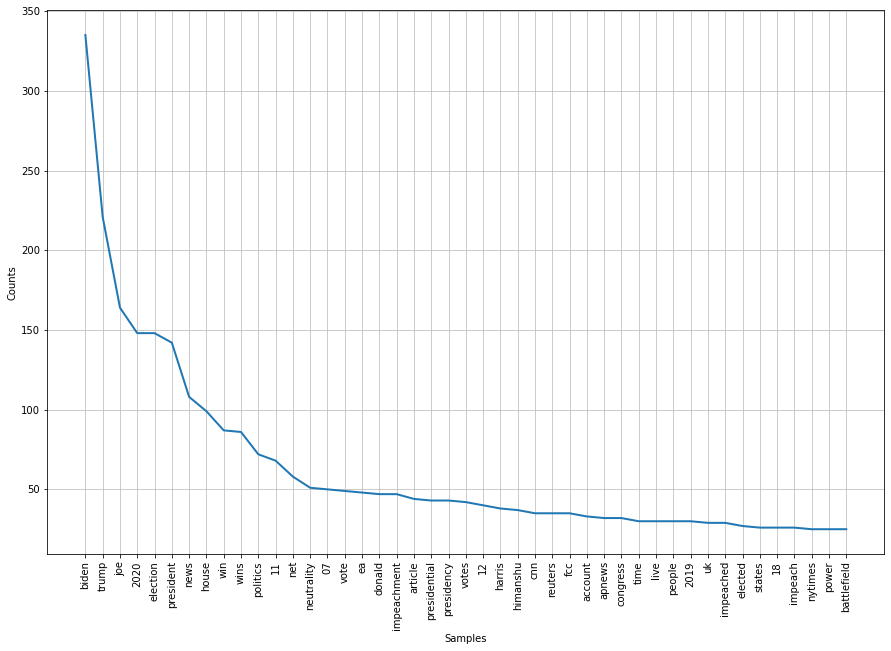

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [188]:
from nltk import FreqDist
freq= FreqDist(new_tok)
plt.subplots(figsize=(15,10))
freq.plot(45)

### Getting content of URL

In [212]:
se= df['url'][15]
se

'https://gfycat.com/ResponsibleJadedAmericancurl'

### Using urllib and beautifulsoup

In [213]:
from bs4 import BeautifulSoup
import urllib.request
html = urllib.request.urlopen(se).read()
soup = BeautifulSoup(html, features="html.parser")
for script in soup(["script", "style"]):
    script.extract()   

texto = soup.get_text()
lines = (line.strip() for line in texto.splitlines())
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
texto = '\n'.join(chunk for chunk in chunks if chunk)

In [214]:
print(texto)

Gas Station Smoking GIF | Gfycat Search millions of user-generated GIFsSearch millions of GIFsSearch GIFs
In GIFsUploadCreateLog InSign Up0.00 sSDUp nextAutoplay Related GIFs7No ads, always HD experience with Gfycat Pro.Get Pro nowGIF21.2M views|Source: liveleak.com|Created Oct 03, 2017smokinggas station


### Using newspaper3k

In [216]:
import newspaper
url_i = newspaper.Article(se)
url_i.download()
url_i.parse()
print(url_i.text)
url_i.nlp()
url_i.keywords

No ads, always HD experience with Gfycat Pro.


['gas',
 'station',
 'hd',
 'experience',
 'smoking',
 'pro',
 'gif',
 'gfycat',
 'ads']

## Making Recommendations based on upvotes

In [189]:
df.sort_values(['Upvotes','Upvote_ratio','DateTime'],ascending=False,inplace=True)
df.head(10)

,title,subreddit,Upvotes,Upvote_ratio,id,url,comms_num,body,NSFW(Not safe for work),DateTime
1,Times Square right now,wallstreetbets,464038,0.99,l8rf4k,https://v.redd.it/x64z70f7eie61,13654,,False,2021-01-30 23:30:38
0,I’ve found a few funny memories during lockdow...,pics,438823,0.99,haucpf,https://i.redd.it/f58v4g8mwh551.jpg,19145,,False,2020-06-17 21:47:27
3,The Senate. Upvote this so that people see it ...,movies,399648,0.96,62sjuh,http://i.imgur.com/ChYwfMq.jpg,4972,,False,2017-04-01 18:27:54
2,Joe Biden elected president of the United States,news,365130,0.88,jptqj9,https://apnews.com/article/election-2020-joe-b...,28637,,False,2020-11-07 21:58:37
6,A short story,memes,361117,0.99,gyfedz,https://i.redd.it/70zdjiilli351.jpg,3670,,False,2020-06-07 21:57:35
5,UPVOTE so everyone sees we got SUPPORT,wallstreetbets,330309,0.97,l6wu59,https://i.redd.it/sgoqy8nyt2e61.png,12940,,False,2021-01-28 19:10:34
12,She did her best ok?,memes,311707,0.98,ig9u4z,https://i.redd.it/g4vm7de3q4j51.jpg,3037,,False,2020-08-25 16:24:00
4,My cab driver tonight was so excited to share ...,funny,308586,0.97,7mjw12,https://i.redd.it/tojcmbvjwk601.jpg,2466,,False,2017-12-28 08:30:55
9,Heat index was 110 degrees so we offered him a...,aww,305648,0.99,90bu6w,https://v.redd.it/gyh95hiqc0b11,3988,,False,2018-07-20 07:14:38
10,GME YOLO update — Jan 28 2021,wallstreetbets,292488,0.98,l78uct,https://i.redd.it/opzucppb15e61.png,23332,,False,2021-01-29 02:36:23


In [193]:
# Considering posts with 200k+ upvotes

df_top= df[df['Upvotes']>200000]
df_top= df_top[df_top['NSFW(Not safe for work)']==False]
df_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 1 to 187
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    142 non-null    object        
 1   subreddit                142 non-null    object        
 2   Upvotes                  142 non-null    int64         
 3   Upvote_ratio             142 non-null    float64       
 4   id                       142 non-null    object        
 5   url                      142 non-null    object        
 6   comms_num                142 non-null    int64         
 7   body                     142 non-null    object        
 8   NSFW(Not safe for work)  142 non-null    bool          
 9   DateTime                 142 non-null    datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 11.2+ KB


In [221]:
df_top['subreddit'].value_counts()

pics                     32
memes                    26
funny                    14
nextfuckinglevel         12
wallstreetbets           11
news                      6
aww                       5
PublicFreakout            4
gaming                    4
gifs                      3
PrequelMemes              2
interestingasfuck         2
thanosdidnothingwrong     2
worldnews                 2
space                     2
MurderedByWords           2
IAmA                      2
Unexpected                1
wholesomememes            1
dankmemes                 1
StarWarsBattlefront       1
mildlyinteresting         1
politics                  1
Showerthoughts            1
AskReddit                 1
videos                    1
movies                    1
MemeEconomy               1
Name: subreddit, dtype: int64

### Recommendable content

In [222]:
# Top 20

df_10_1=df_top[:20]
df_10_1.to_csv('df_1_jun_16.csv')

In [223]:
df_10_1

,title,subreddit,Upvotes,Upvote_ratio,id,url,comms_num,body,NSFW(Not safe for work),DateTime
1,Times Square right now,wallstreetbets,464038,0.99,l8rf4k,https://v.redd.it/x64z70f7eie61,13654,,False,2021-01-30 23:30:38
0,I’ve found a few funny memories during lockdow...,pics,438823,0.99,haucpf,https://i.redd.it/f58v4g8mwh551.jpg,19145,,False,2020-06-17 21:47:27
3,The Senate. Upvote this so that people see it ...,movies,399648,0.96,62sjuh,http://i.imgur.com/ChYwfMq.jpg,4972,,False,2017-04-01 18:27:54
2,Joe Biden elected president of the United States,news,365130,0.88,jptqj9,https://apnews.com/article/election-2020-joe-b...,28637,,False,2020-11-07 21:58:37
6,A short story,memes,361117,0.99,gyfedz,https://i.redd.it/70zdjiilli351.jpg,3670,,False,2020-06-07 21:57:35
5,UPVOTE so everyone sees we got SUPPORT,wallstreetbets,330309,0.97,l6wu59,https://i.redd.it/sgoqy8nyt2e61.png,12940,,False,2021-01-28 19:10:34
12,She did her best ok?,memes,311707,0.98,ig9u4z,https://i.redd.it/g4vm7de3q4j51.jpg,3037,,False,2020-08-25 16:24:00
4,My cab driver tonight was so excited to share ...,funny,308586,0.97,7mjw12,https://i.redd.it/tojcmbvjwk601.jpg,2466,,False,2017-12-28 08:30:55
9,Heat index was 110 degrees so we offered him a...,aww,305648,0.99,90bu6w,https://v.redd.it/gyh95hiqc0b11,3988,,False,2018-07-20 07:14:38
10,GME YOLO update — Jan 28 2021,wallstreetbets,292488,0.98,l78uct,https://i.redd.it/opzucppb15e61.png,23332,,False,2021-01-29 02:36:23
